In [422]:
import qutip as qt
import krotov as kt
import numpy as np
import matplotlib.pyplot as plt

Scaling time and frequency differently: one time unit below is one microsecond, so one frequency unit below should be scaled by 1e6 to get rad/s.

In [423]:
N = 4
T = 25e-6
cs_strength = 1e2
omega_nut = 5e4
lambda_a = 1e6

In [424]:
I_x = sum([
    qt.tensor(  # I_x^i
        [qt.identity(2)]*i
        + [qt.sigmax()]
        + [qt.identity(2)]*(N-i-1)
    )
    for i in range(N)
])

I_y = sum([
    qt.tensor(  # I_x^i
        [qt.identity(2)]*i
        + [qt.sigmay()]
        + [qt.identity(2)]*(N-i-1)
    )
    for i in range(N)
])

I_z = sum([
    qt.tensor(  # I_x^i
        [qt.identity(2)]*i
        + [qt.sigmaz()]
        + [qt.identity(2)]*(N-i-1)
    )
    for i in range(N)
])

In [425]:
def hamiltonian(N=4, cs_strength=1, a0=1, a1=1):
    """System of N spin-1/2 particles
    
    Arguments:
        N (int): Number of particles
        cs_strength (float): Strength of chemical shift interaction, in rad/s
        a0 (float): Initial amplitude of first control Hamiltonian
        a1 (float): Initial amplitude of second control Hamiltonian
    """
    chemical_shift = np.random.normal(scale=cs_strength, size=(N,))
    H_cs = sum([
        qt.tensor([qt.identity(2)]*i
               + [chemical_shift[i] * qt.sigmaz()]
               + [qt.identity(2)]*(N-i-1))
        for i in range(N)
    ])
    H_cx = omega_nut * I_x
    H_cy = omega_nut * I_y
    
    def cx(t, args):
        return a0 * kt.shapes.flattop(
            t, t_start=0, t_stop=T, t_rise=T/10, func='blackman'
        )
    def cy(t, args):
        return a1 * kt.shapes.flattop(
            t, t_start=0, t_stop=T, t_rise=T/10, func='blackman'
        )
    
    return [H_cs, [H_cx, cx], [H_cy, cy]]

In [426]:
H_c_labels = [
    r'$H_x$',
    r'$H_y$',
]

In [427]:
H = hamiltonian(N=N, cs_strength=cs_strength, a0=.7, a1=2e-4)

In [428]:
tlist = np.linspace(0, T, 100)

In [429]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

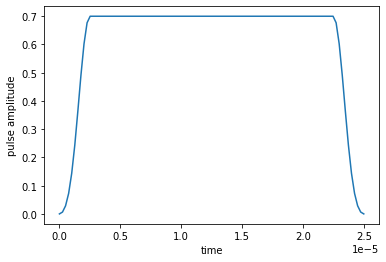

In [430]:
plot_pulse(H[1][1], tlist)

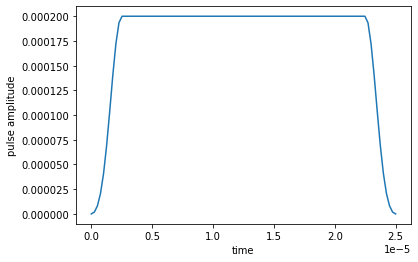

In [431]:
plot_pulse(H[2][1], tlist)

In [432]:
#  2**N basis states
basis_states = [
    qt.tensor(
        [qt.basis(2, np.mod(int(np.floor(i / 2**j)), 2)) for j in range(N)]
    ) for i in range(2**N)
]

In [433]:
U_targ = qt.propagator(I_x, np.pi/4)

In [434]:
objectives = kt.gate_objectives(
    basis_states=basis_states,
    gate=U_targ,
    H=H
)

In [435]:
def S(t):
    """Shape function for the field update"""
    return kt.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=T/10, t_fall=T/10, func='blackman'
    )

In [436]:
pulse_options = {
    H[1][1]: dict(lambda_a=lambda_a, update_shape=S),
    H[2][1]: dict(lambda_a=lambda_a, update_shape=S),
}

In [437]:
e_ops = [
    I_x, I_y, I_z
]

e_labels = [
    r'$I_x$',
    r'$I_y$',
    r'$I_z$',
]

In [438]:
guess_dynamics = objectives[0].mesolve(tlist, e_ops=e_ops)

In [439]:
def plot_population(result, e_labels):
    fig, ax = plt.subplots()
    for i, label in enumerate(e_labels):
        ax.plot(result.times, result.expect[i], label=label)
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('expectation value')
    plt.show(fig)

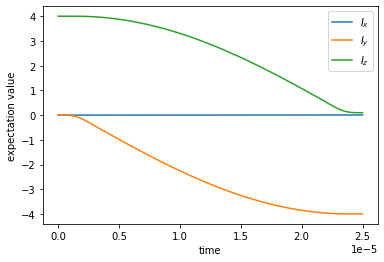

In [440]:
plot_population(guess_dynamics, e_labels)

In [441]:
opt_result = kt.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=kt.propagators.expm,
    chi_constructor=kt.functionals.chis_ss,
    info_hook=kt.info_hooks.print_table(J_T=kt.functionals.J_T_ss),
    check_convergence=kt.convergence.Or(
        kt.convergence.value_below('1e-3', name='J_T'),
        kt.convergence.check_monotonic_error,
    ),
    store_all_pulses=True,
)

iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     5.72e-04    0.00e+00   5.72e-04        n/a        n/a     5
1     3.68e-04    9.93e-11   3.68e-04  -2.04e-04  -2.04e-04    10


In [442]:
# TODO figure out why it's not converging....!!!!

In [443]:
opt_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=e_ops)

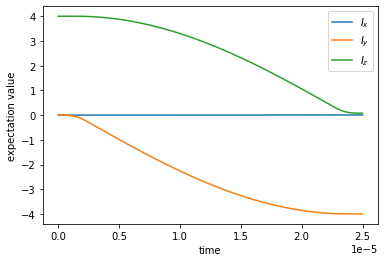

In [444]:
plot_population(opt_dynamics, e_labels)

In [445]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [446]:
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """
    fig, [ax_ctr0, ax_ctr1, ax_dyn] = plt.subplots(
        nrows=3, ncols=1,
        figsize=(8, 12),
        sharex=True
    )
    n_iters = len(opt_result.iters)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            kt.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=e_ops
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = [f'{label} (guess)' for label in e_labels] # '0 (guess)', '1 (guess)'
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = [f'{label} (optimized)' for label in e_labels]
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None] * len(e_labels)
        ax_ctr0.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
        ax_ctr1.plot(
            dynamics.times,
            controls[1],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
        for i in range(len(e_labels)):
            ax_dyn.plot(
                dynamics.times,
                dynamics.expect[i],
                # TODO figure out below
                label=pop_labels[i],
                color=colors[i],
                ls=ls,
                alpha=alpha,
            )
    ax_dyn.legend()
    ax_dyn.set_xlabel('time')
    ax_dyn.set_ylabel('expectation')
    ax_ctr0.set_title(H_c_labels[0])
    ax_ctr0.legend()
    ax_ctr0.set_xlabel('time')
    ax_ctr0.set_ylabel('control amplitude')
    ax_ctr1.set_title(H_c_labels[1])
    ax_ctr1.legend()
    ax_ctr1.set_xlabel('time')
    ax_ctr1.set_ylabel('control amplitude')
    plt.show(fig)

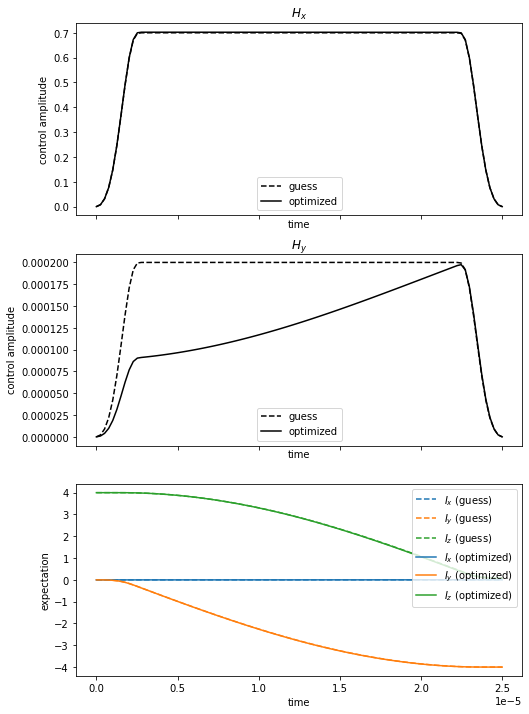

In [447]:
plot_iterations(opt_result)